In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
import scipy
from logP import *
from get_pyrosetta_scores import get_pyrosetta_scores_from_sequence
from bmDCA import *
from matplotlib import pyplot as plt
import gc
import time
import tracemalloc

/home/joseph/summer2020_personal/Bayesian_Optimization/utils.py:2: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.loops.loop_closure.kinematic_closure import *


PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
[Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', 

In [7]:

def hammingDist(str1, str2): 
    count = 0 
    for i in range(len(str1)):
        if(str2[i] != str1[i]):
            count+=1
    return count/len(str1)



In [3]:
# scalarization of objectives (y)
# sum of coefficients equals one
# will minimize "cost"
# calculate scalarized cost for a single y value
vae = VAE_Operator()

def multi_dimensional_score(x):
    sequence = vae.get_seq_from_z(x)
    vae_prob = vae.get_score_from_z(x)[0] 
    pyr_score = get_pyrosetta_scores_from_sequence(sequence) * (-1)
    dca = DCA_scorer()
    dca_prob = dca.get_dca_scores_from_seq(sequence)[0] 
    functionality_score = hammingDist("A"*62, sequence)
    return [vae_prob, pyr_score, dca_prob, functionality_score]

def scalarized_cost(y_singular,lambda_,rho=0.05):
    lambda_ /= np.sum(lambda_)
    p = np.multiply(y_singular, lambda_)
    return np.max(p) + np.sum(p * rho)

#calculate cost for the entire field of observations
def calc_scal_from_observations(y):
    lambda_ = np.random.random(len(y[0]))
    lambda_ /= np.sum(lambda_)
    scalar_scores = np.zeros(len(y))
    for counter, y_singular in enumerate(y):
        cost = scalarized_cost(y_singular, lambda_)
        scalar_scores[counter] = cost
    return (scalar_scores, lambda_)

#expected improvement (to be maximized across whole x_space)
def EI(muNew, stdNew, fMax, epsilon=0.01):
    """
    Expected improvement acquisition function
    INPUT:
    - muNew: mean of predicted point in grid
    - stdNew: sigma (square root of variance) of predicted point in grid
    - fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
    - epsilon: trade-off parameter (>=0)
    [Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])
    OUTPUT:
    - EI: expected improvement for candidate point
    As describend in:
    E Brochu, VM Cora, & N de Freitas (2010):
    A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
    arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
    """

    Z = (muNew - fMax - epsilon) / stdNew

    return (muNew - fMax - epsilon) * scipy.stats.norm.cdf(
        Z
    ) + stdNew * scipy.stats.norm.pdf(Z) * (-1)



In [46]:
class BO():
    def __init__(self, initial_x, initial_y):
        self.model = GaussianProcessRegressor()
        self.observed_x = initial_x
        self.observed_y = initial_y
        self.observed_y_scalarized, _ = calc_scal_from_observations(self.observed_y)
        self.model.fit(self.observed_x, self.observed_y_scalarized)
        self.average_scores = np.zeros(1)
        self.memory_alloc_fitting = np.zeros(1)
        self.memory_alloc_predicting = np.zeros(1)

        
    def propose_new(self, resolution=1000000, dim=3):
        best = np.max(self.observed_y_scalarized)
        x_space = np.random.randn(resolution,dim)#generate a bunch of random sequences to maximize acq
        mu, std = self.model.predict(x_space, return_std = True)
        #evaluate ei at a bunch of points in x_space
        scores = EI(mu, std, best)
        #maximize ei
        max_i = np.argmax(scores) 
        new_point = x_space[max_i]
        print(new_point, "-suggested new point")
        return new_point
    
    
    def run_BO(self, num_iter=100):
        start_t = time.time()
        time.clock()    
        self.average_scores = np.zeros((num_iter, len(self.observed_y[0])))
        for num_round in range(num_iter):
            
            #1) calculate random scalarization for this round
            tracemalloc.start()
            current, peak = tracemalloc.get_traced_memory()
            self.observed_y_scalarized, lambda_ = calc_scal_from_observations(self.observed_y)
            print("Memory Used For Calculating Scalarized scores Point: ", peak)
            tracemalloc.stop()
            
            #2) Fit GPR to this scalarization
            tracemalloc.start()
            self.model.fit(self.observed_x, self.observed_y_scalarized)
            current, peak = tracemalloc.get_traced_memory()
            plt.plot(range(len(self.observed_y_scalarized)), self.observed_y_scalarized)
            plt.show()
            print("Round ", num_round, " mean score: ", np.mean(self.observed_y_scalarized))
            print("Random Scalarization (Lambda): ", lambda_)
            print("Memory Used For Fitting: ", peak)
            tracemalloc.stop()

            #3) Propose new point
            tracemalloc.start()
            new_point_to_check = self.propose_new()
            current, peak = tracemalloc.get_traced_memory()
            print("Memory Used For Proposing New Point: ", peak)
            tracemalloc.stop()   
            
            #4) Score new point
            tracemalloc.start()
            self.observed_x = np.vstack([self.observed_x, new_point_to_check])
            self.observed_y = np.vstack([self.observed_y, multi_dimensional_score(new_point_to_check)])
            current, peak = tracemalloc.get_traced_memory()
            print("Memory Used For Scoring New Point: ", peak)
            tracemalloc.stop()  
            
            #5) Calculate average scores for analysis
            for i in range(len(self.observed_y[0])):
                self.average_scores[num_round][i] = np.mean(self.observed_y[:,i])
            print((1.0- num_round/num_iter) * (time.time()-start_t)/(num_round+1))
            print("ETA: ", int((num_iter-num_round) * (time.time()-start_t)/(num_round+1)), " seconds")
            print("------------------------------------------------------------------------")
            print()
            gc.collect()
            np.savetxt("data/round"+str(i)+"_observed_points.txt", self.observed_x)
            np.savetxt("data/round"+str(i)+"_observed_scores.txt", self.observed_y)


In [13]:
initial_x = np.random.randn(10,3)
initial_y = np.array([multi_dimensional_score(i) for i in initial_x])

In [47]:
bayesian_optimizer = BO(initial_x, initial_y)

Memory Used For Calculating Scalarized scores Point:  0


/home/joseph/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


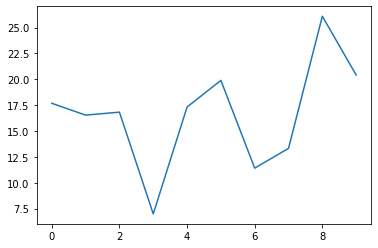

Round  0  mean score:  16.65012686145087
Random Scalarization (Lambda):  [0.52374927 0.16985462 0.2016774  0.10471872]
Memory Used For Fitting:  10305
[-0.33169605  0.89135445  0.04524024] -suggested new point
Memory Used For Proposing New Point:  34401563
Memory Used For Scoring New Point:  100579342
2.1435837745666504
ETA:  64  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


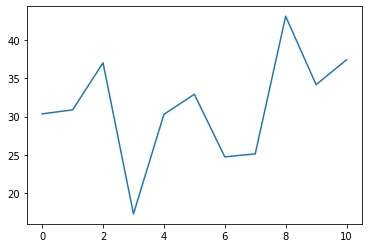

Round  1  mean score:  31.205894715166572
Random Scalarization (Lambda):  [0.14854554 0.14209119 0.30685135 0.40251192]
Memory Used For Fitting:  10368
[-0.5240678   1.48858881  0.63352477] -suggested new point
Memory Used For Proposing New Point:  37601305
Memory Used For Scoring New Point:  100579292
2.0780035058657327
ETA:  62  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


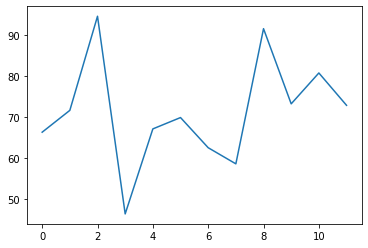

Round  2  mean score:  71.33142224272824
Random Scalarization (Lambda):  [0.31397349 0.06186869 0.60668045 0.01747737]
Memory Used For Fitting:  12445
[-1.20482964  0.96551703  0.30669759] -suggested new point
Memory Used For Proposing New Point:  40801305
Memory Used For Scoring New Point:  100579292
1.9642125129699706
ETA:  58  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


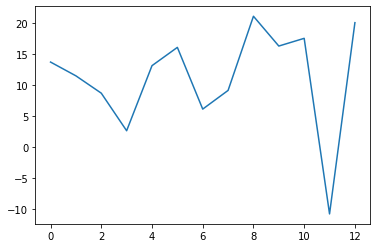

Round  3  mean score:  11.218041409021728
Random Scalarization (Lambda):  [0.32990853 0.21149324 0.17742593 0.28117231]
Memory Used For Fitting:  13136
[-0.62202687  1.95078684 -0.45181809] -suggested new point
Memory Used For Proposing New Point:  44001305
Memory Used For Scoring New Point:  100579292
1.9129849433898927
ETA:  57  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


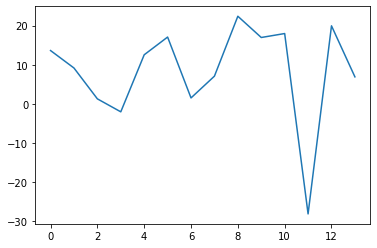

Round  4  mean score:  8.289138392474536
Random Scalarization (Lambda):  [0.07523071 0.34344923 0.21015492 0.37116514]
Memory Used For Fitting:  13277
[-0.1505527   0.0308129  -1.45421778] -suggested new point
Memory Used For Proposing New Point:  47204476
Memory Used For Scoring New Point:  100579292
1.8666369247436525
ETA:  55  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


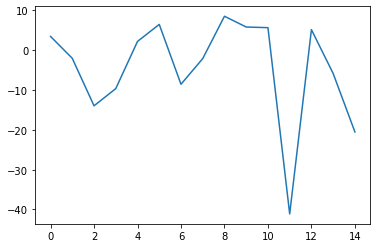

Round  5  mean score:  -4.461278454540297
Random Scalarization (Lambda):  [0.35129123 0.34760615 0.12085542 0.1802472 ]
Memory Used For Fitting:  14032
[-1.21701641 -0.14415884  1.53819534] -suggested new point
Memory Used For Proposing New Point:  50401011
Memory Used For Scoring New Point:  100579068
1.7785476313696968
ETA:  53  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


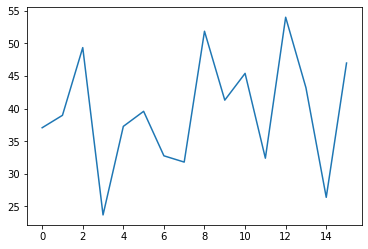

Round  6  mean score:  39.48807835868821
Random Scalarization (Lambda):  [0.29936023 0.09842219 0.35530346 0.24691412]
Memory Used For Fitting:  14613
[-1.13159092  0.30847395  0.94831042] -suggested new point
Memory Used For Proposing New Point:  53601257
Memory Used For Scoring New Point:  100579204
1.8571673257010326
ETA:  55  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


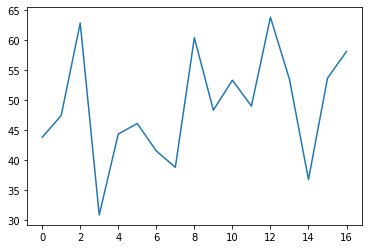

Round  7  mean score:  49.016631466059074
Random Scalarization (Lambda):  [0.27672742 0.03413929 0.39899395 0.29013934]
Memory Used For Fitting:  15881
[-0.95280722  1.20945649  0.12487111] -suggested new point
Memory Used For Proposing New Point:  56801483
Memory Used For Scoring New Point:  100579292
1.7656217743953069
ETA:  52  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


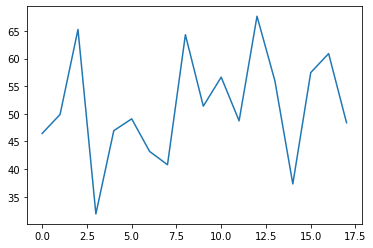

Round  8  mean score:  51.24730375639091
Random Scalarization (Lambda):  [0.38672818 0.06100976 0.42939583 0.12286623]
Memory Used For Fitting:  16265
[ 0.12905365  2.0733333  -0.27044422] -suggested new point
Memory Used For Proposing New Point:  60001483
Memory Used For Scoring New Point:  100579292
1.6740318368982388
ETA:  50  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


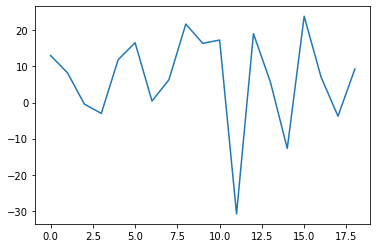

Round  9  mean score:  6.651250388496418
Random Scalarization (Lambda):  [0.07730064 0.35884131 0.20909549 0.35476257]
Memory Used For Fitting:  17705
[-2.17579684  0.1940017   0.07125929] -suggested new point
Memory Used For Proposing New Point:  63201257
Memory Used For Scoring New Point:  100579204
1.5644016098976135
ETA:  46  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


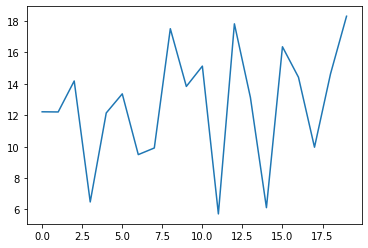

Round  10  mean score:  12.648134914384396
Random Scalarization (Lambda):  [0.2574601  0.07052927 0.12696492 0.54504571]
Memory Used For Fitting:  18793
[-1.43915884 -0.77461802  2.10310559] -suggested new point
Memory Used For Proposing New Point:  66404480
Memory Used For Scoring New Point:  100579292
1.4457241260644162
ETA:  43  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


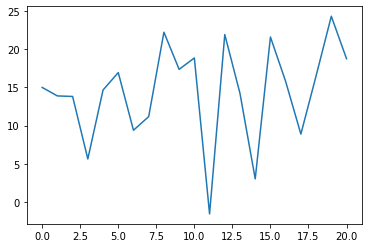

Round  11  mean score:  14.392539693995664
Random Scalarization (Lambda):  [0.5091293  0.15233088 0.17313839 0.16540144]
Memory Used For Fitting:  19609
[-1.84933733  0.63480626  0.56791396] -suggested new point
Memory Used For Proposing New Point:  69604480
Memory Used For Scoring New Point:  100579292
1.3692229529221853
ETA:  41  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


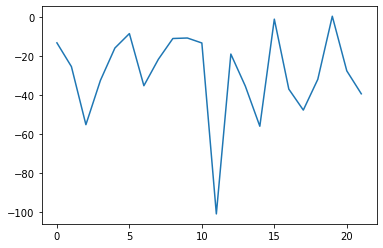

Round  12  mean score:  -28.971451927750206
Random Scalarization (Lambda):  [0.22925778 0.65131865 0.05192431 0.06749926]
Memory Used For Fitting:  20897
[-1.63346388  0.06440777 -0.39083993] -suggested new point
Memory Used For Proposing New Point:  72801257
Memory Used For Scoring New Point:  100579204
1.2873125883249135
ETA:  38  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


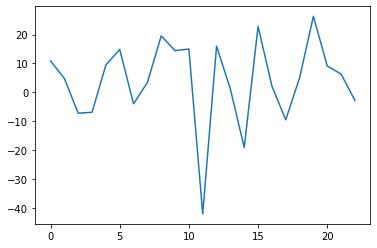

Round  13  mean score:  3.8772741656064578
Random Scalarization (Lambda):  [0.18053923 0.42505899 0.20705784 0.18734394]
Memory Used For Fitting:  20657
[-0.66296055  2.6298849  -1.08037127] -suggested new point
Memory Used For Proposing New Point:  76004480
Memory Used For Scoring New Point:  100579292
1.2203145407495044
ETA:  36  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


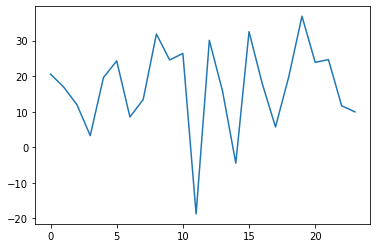

Round  14  mean score:  16.9447978003074
Random Scalarization (Lambda):  [0.1568306  0.33619038 0.27023629 0.23674273]
Memory Used For Fitting:  22553
[ 0.61148931 -0.17208503 -0.82703785] -suggested new point
Memory Used For Proposing New Point:  79201257
Memory Used For Scoring New Point:  100579278
1.166396687825521
ETA:  34  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


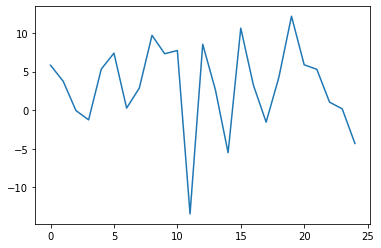

Round  15  mean score:  3.104247917140857
Random Scalarization (Lambda):  [0.29156612 0.15768152 0.09264571 0.45810665]
Memory Used For Fitting:  23364
[-1.87573798 -1.38570113  0.69167274] -suggested new point
Memory Used For Proposing New Point:  82401257
Memory Used For Scoring New Point:  100579398
1.1053726822137833
ETA:  33  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


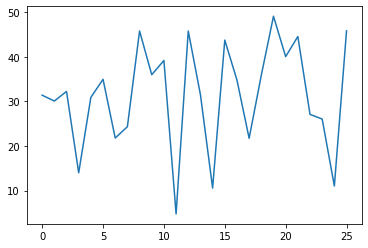

Round  16  mean score:  31.279333723278572
Random Scalarization (Lambda):  [0.0180532 0.25741   0.3460834 0.3784534]
Memory Used For Fitting:  23777
[-0.94003059 -0.30213984  2.10855949] -suggested new point
Memory Used For Proposing New Point:  85604472
Memory Used For Scoring New Point:  100579292
1.0250660606459074
ETA:  30  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


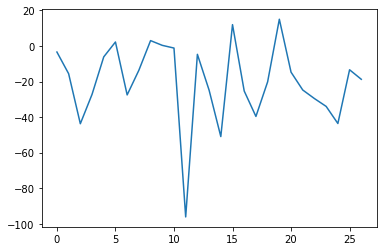

Round  17  mean score:  -20.215662414704727
Random Scalarization (Lambda):  [0.12400718 0.70525536 0.15287921 0.01785825]
Memory Used For Fitting:  25340
[ 0.41980957 -2.27013485 -1.41414284] -suggested new point
Memory Used For Proposing New Point:  88801257
Memory Used For Scoring New Point:  100579398
0.9624416713361388
ETA:  28  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


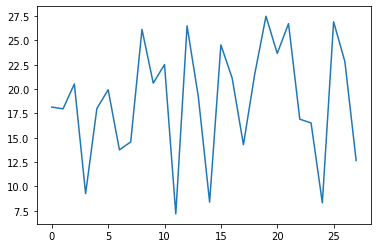

Round  18  mean score:  18.785646433062983
Random Scalarization (Lambda):  [0.41965924 0.11488865 0.1913994  0.27405271]
Memory Used For Fitting:  26404
[0.03571817 1.35369754 0.14758446] -suggested new point
Memory Used For Proposing New Point:  92004480
Memory Used For Scoring New Point:  100579654
0.8863780573794717
ETA:  26  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


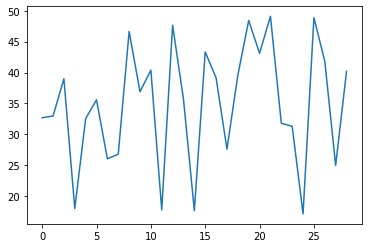

Round  19  mean score:  34.925286208249574
Random Scalarization (Lambda):  [0.241073   0.1694988  0.33490558 0.25452261]
Memory Used For Fitting:  28100
[-0.34071046  2.35478372 -0.58984086] -suggested new point
Memory Used For Proposing New Point:  95201257
Memory Used For Scoring New Point:  100579004
0.8091709391276043
ETA:  24  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


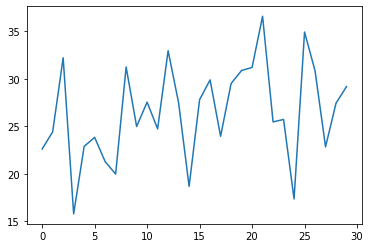

Round  20  mean score:  26.48063215159296
Random Scalarization (Lambda):  [0.43927093 0.02207112 0.20713156 0.3315264 ]
Memory Used For Fitting:  28076
[-1.41814994  0.59774316  0.50310803] -suggested new point
Memory Used For Proposing New Point:  98404478
Memory Used For Scoring New Point:  100579068
0.7329356594691202
ETA:  21  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


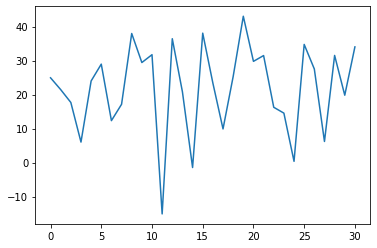

Round  21  mean score:  21.877374070041895
Random Scalarization (Lambda):  [0.2283296  0.34929563 0.312596   0.10977877]
Memory Used For Fitting:  29201
[-2.59712292  1.06703718  0.04713331] -suggested new point
Memory Used For Proposing New Point:  101604480
Memory Used For Scoring New Point:  100579310
0.6572806184942073
ETA:  19  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


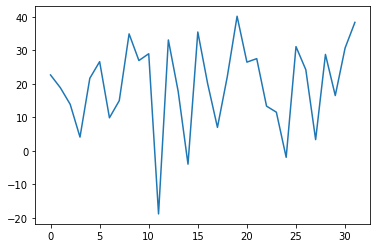

Round  22  mean score:  19.553942858241008
Random Scalarization (Lambda):  [0.11183843 0.35605467 0.29373253 0.23837436]
Memory Used For Fitting:  31017
[-0.74357952 -0.75494977  1.2409778 ] -suggested new point
Memory Used For Proposing New Point:  104801257
Memory Used For Scoring New Point:  100579398
0.5903477710226309
ETA:  17  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


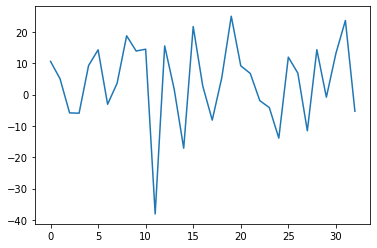

Round  23  mean score:  3.982338013635621
Random Scalarization (Lambda):  [0.04163486 0.39105627 0.19540963 0.37189924]
Memory Used For Fitting:  32212
[1.50317907 0.42407152 0.98279911] -suggested new point
Memory Used For Proposing New Point:  108001257
Memory Used For Scoring New Point:  100579398
0.517682835790846
ETA:  15  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


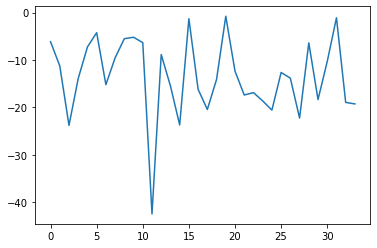

Round  24  mean score:  -13.54491237813072
Random Scalarization (Lambda):  [0.30189147 0.26800758 0.01477724 0.41532371]
Memory Used For Fitting:  33444
[-2.82718934 -0.37290534 -0.20716085] -suggested new point
Memory Used For Proposing New Point:  111204480
Memory Used For Scoring New Point:  100579534
0.44001632118225087
ETA:  13  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


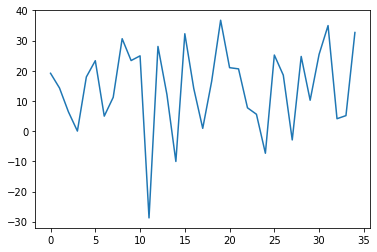

Round  25  mean score:  14.4111173313251
Random Scalarization (Lambda):  [0.18984434 0.40001522 0.27450932 0.13563111]
Memory Used For Fitting:  36012
[-0.24054603  0.51575724  0.62800873] -suggested new point
Memory Used For Proposing New Point:  114401257
Memory Used For Scoring New Point:  100579204
0.36712471796916074
ETA:  11  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


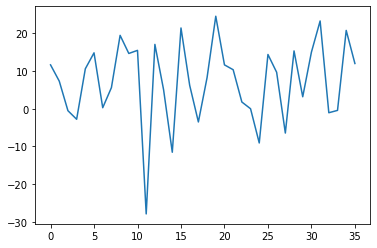

Round  26  mean score:  7.109576670950148
Random Scalarization (Lambda):  [0.27551846 0.32262916 0.1871719  0.21468047]
Memory Used For Fitting:  36140
[-1.22047655  2.31365293 -1.85785207] -suggested new point
Memory Used For Proposing New Point:  117601257
Memory Used For Scoring New Point:  100579398
0.293614630051601
ETA:  8  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


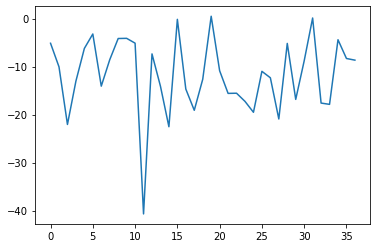

Round  27  mean score:  -11.807114848725456
Random Scalarization (Lambda):  [0.4938022  0.26416983 0.02305801 0.21896996]
Memory Used For Fitting:  38600
[1.54951167 1.55194581 1.1201155 ] -suggested new point
Memory Used For Proposing New Point:  120804482
Memory Used For Scoring New Point:  100579654
0.2199408982481275
ETA:  6  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


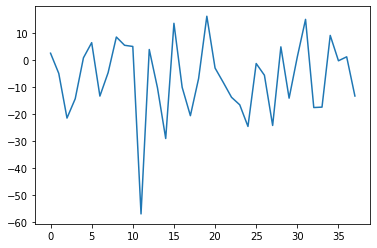

Round  28  mean score:  -6.692872405751117
Random Scalarization (Lambda):  [0.18379708 0.46095924 0.14318478 0.21205889]
Memory Used For Fitting:  39696
[-2.49540549  0.07198894 -0.31115393] -suggested new point
Memory Used For Proposing New Point:  124001483
Memory Used For Scoring New Point:  100579654
0.14700469312996697
ETA:  4  seconds
------------------------------------------------------------------------

Memory Used For Calculating Scalarized scores Point:  0


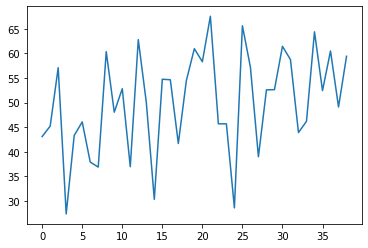

Round  29  mean score:  50.11057282231538
Random Scalarization (Lambda):  [0.1442865  0.11979243 0.41465622 0.32126484]
Memory Used For Fitting:  41400
[-2.14480344  1.2532036   0.69561892] -suggested new point
Memory Used For Proposing New Point:  127201257
Memory Used For Scoring New Point:  100579398
0.07388441377215912
ETA:  2  seconds
------------------------------------------------------------------------



In [48]:
bayesian_optimizer.run_BO(30)

In [49]:
bayesian_optimizer.average_scores

array([[-1.10860697e+00, -8.69852621e+02,  1.16002896e+02,
         9.25219941e-01],
       [-1.08291930e+00, -1.07398933e+03,  1.17218575e+02,
         9.26075269e-01],
       [-1.03174393e+00, -1.05615401e+03,  1.20186896e+02,
         9.28039702e-01],
       [-1.02686279e+00, -1.07424050e+03,  1.21103762e+02,
         9.30875576e-01],
       [-1.05718923e+00, -1.12786418e+03,  1.19399214e+02,
         9.29032258e-01],
       [-1.03934537e+00, -1.07282897e+03,  1.20009270e+02,
         9.27419355e-01],
       [-1.01924392e+00, -1.09063661e+03,  1.21445878e+02,
         9.25996205e-01],
       [-1.00794872e+00, -1.12242803e+03,  1.21289009e+02,
         9.28315412e-01],
       [-9.86633622e-01, -1.12739448e+03,  1.22369979e+02,
         9.29541596e-01],
       [-9.54333520e-01, -1.08226624e+03,  1.23406717e+02,
         9.26612903e-01],
       [-9.20108209e-01, -1.08289402e+03,  1.24624951e+02,
         9.23963134e-01],
       [-8.92371427e-01, -1.10194367e+03,  1.26951874e+02,
      

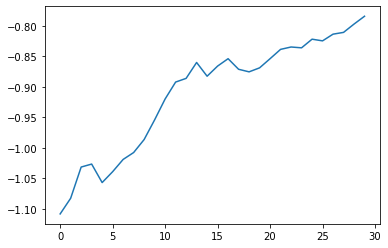

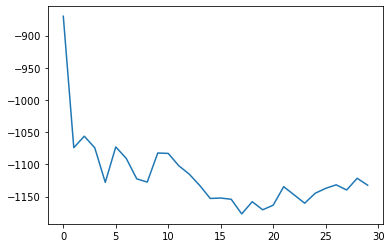

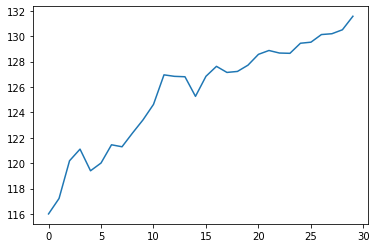

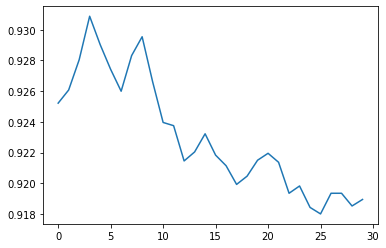

In [50]:
for i in range(len(bayesian_optimizer.average_scores[0])):
    plt.plot(range(30), bayesian_optimizer.average_scores[:,i])
    plt.show()